# Contexto

Reto planteado en el curso: Rudimentos de Machine Learning del colegio Bourbaki, el objetivo es  predecir el precio de venta de propiedades usando regresión líneal o un árbol de decisión.

# Librerias

In [1]:
#Data Analysis
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

# Utils
import os
from IPython.display import Image, display
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler

# Funciones de ayuda

In [2]:
def high_correlation_features(dataframe, threshold=0.95):
    """
    Identifies and returns pairs of highly correlated features from the given dataframe.

    Parameters:
    - dataframe: A pandas DataFrame containing the dataset.
    - threshold: A float representing the correlation threshold to identify high correlations.

    Returns:
    - A DataFrame with pairs of features that have a correlation coefficient above the threshold.
    """
    # Calculate the correlation matrix
    corr_matrix = dataframe.corr()

    # Find features with a correlation above the threshold
    # Note: The matrix is symmetric, so we need to filter out one side to avoid duplicates
    high_corr_pairs = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                       .stack()
                       .reset_index())
    high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
    high_corr_pairs = high_corr_pairs.loc[high_corr_pairs['Correlation'] > threshold, :]

    return high_corr_pairs

In [3]:
def normality_test(data):
    # D'Agostino-Pearson Test
    stat, p = stats.normaltest(data)
    print("D'Agostino-Pearson Test")
    print("Test Statistic:", stat)
    print("p-value:", p)
    if p < 0.05:
        print("Conclusion: According to the D'Agostino-Pearson Test, the data is not normally distributed.\n")
    else:
        print("Conclusion: According to the D'Agostino-Pearson Test, the data is normally distributed.\n")
    
    # Shapiro-Wilk Test
    stat, p = stats.shapiro(data)
    print("Shapiro-Wilk Test")
    print("Test Statistic:", stat)
    print("p-value:", p)
    if p < 0.05:
        print("Conclusion: According to the Shapiro-Wilk Test, the data is not normally distributed.\n")
    else:
        print("Conclusion: According to the Shapiro-Wilk Test, the data is normally distributed.\n")
    
    # Kolmogorov-Smirnov Test
    stat, p = stats.kstest(data, 'norm')
    print("Kolmogorov-Smirnov Test")
    print("Test Statistic:", stat)
    print("p-value:", p)
    if p < 0.05:
        print("Conclusion: According to the Kolmogorov-Smirnov Test, the data is not normally distributed.\n")
    else:
        print("Conclusion: According to the Kolmogorov-Smirnov Test, the data is normally distributed.\n")
    
    # Anderson-Darling Test
    result = stats.anderson(data)
    print("Anderson-Darling Test")
    print("Test Statistic:", result.statistic)
    for i in range(len(result.critical_values)):
        significance_level, critical_value = result.significance_level[i], result.critical_values[i]
        print(f'At {significance_level}% significance level, critical value is {critical_value}')
        if result.statistic > critical_value:
            print(f"Conclusion at {significance_level}% significance level: According to the Anderson-Darling Test, the data is not normally distributed.\n")
        else:
            print(f"Conclusion at {significance_level}% significance level: According to the Anderson-Darling Test, the data is normally distributed.\n")

In [4]:
def laplace_test(data):
    # Fit the data to a Laplace distribution and get the parameters
    loc, scale = stats.laplace.fit(data)
    
    # Kolmogorov-Smirnov Test for Laplace distribution
    stat, p = stats.kstest(data, 'laplace', args=(loc, scale))
    print("Kolmogorov-Smirnov Test for Laplace Distribution")
    print("Test Statistic:", stat)
    print("p-value:", p)
    if p < 0.05:
        print("Conclusion: According to the Kolmogorov-Smirnov Test, the data is not distributed like a Laplace distribution.\n")
    else:
        print("Conclusion: According to the Kolmogorov-Smirnov Test, the data is distributed like a Laplace distribution.\n")

# Lectura

In [5]:
#print(os.listdir('.'))'Datos Examen 2 .csv'
df = pd.read_csv('./Datos Examen 2 .csv')
df.tail(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


# Exploración

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Las variables:

    * PoolQC
    * Fence
    * MiscFeature

Tienen pocos valores no nulos

In [7]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Distribución de las columnas numéricas

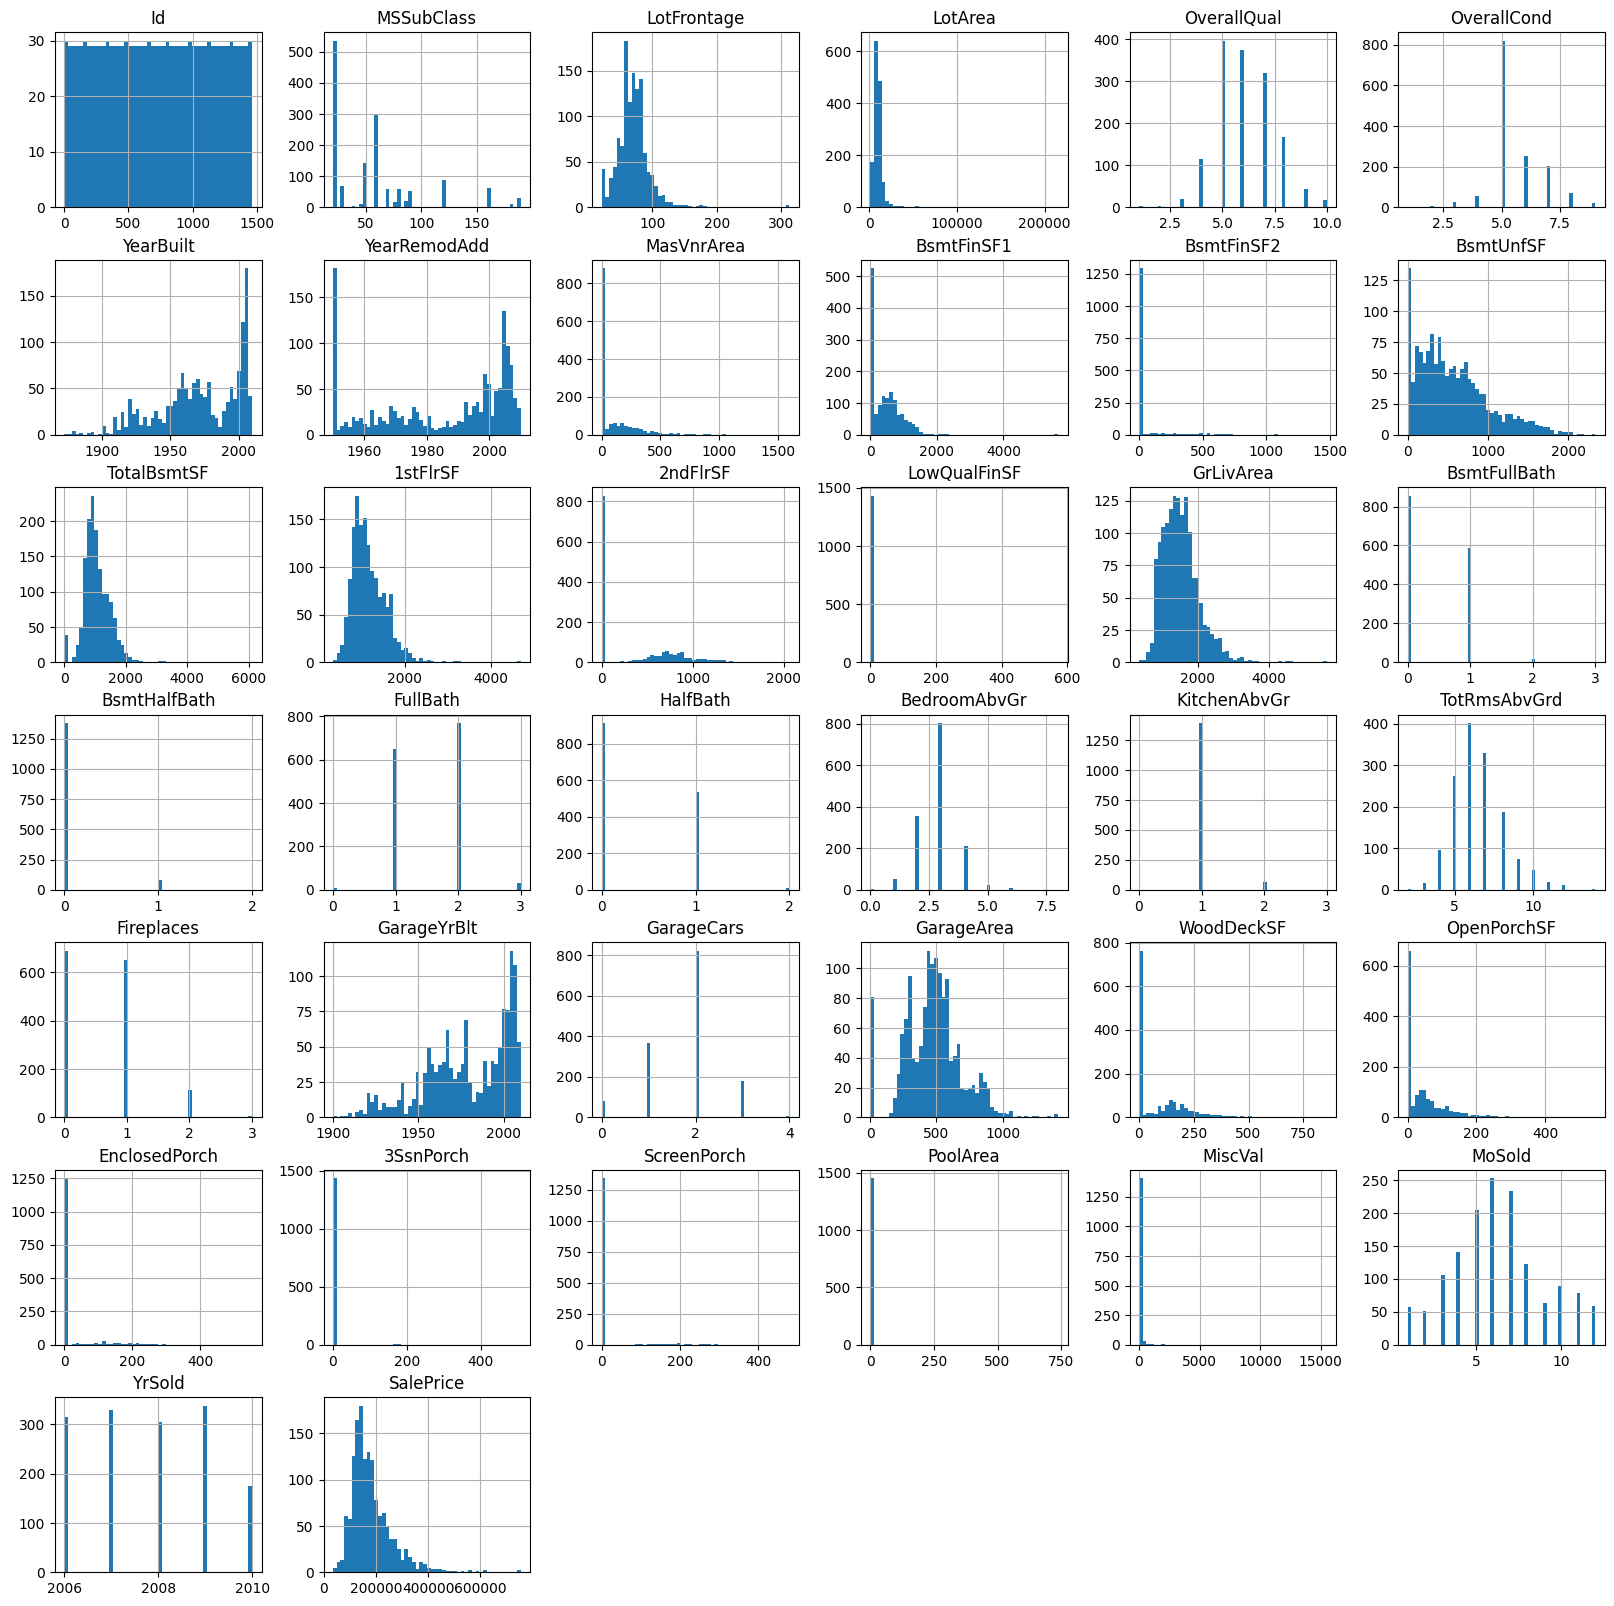

In [8]:
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols].hist(bins=50, figsize=(20, 20),sharex=False, sharey=False)
plt.show()

## Distribución del precio y tamaño

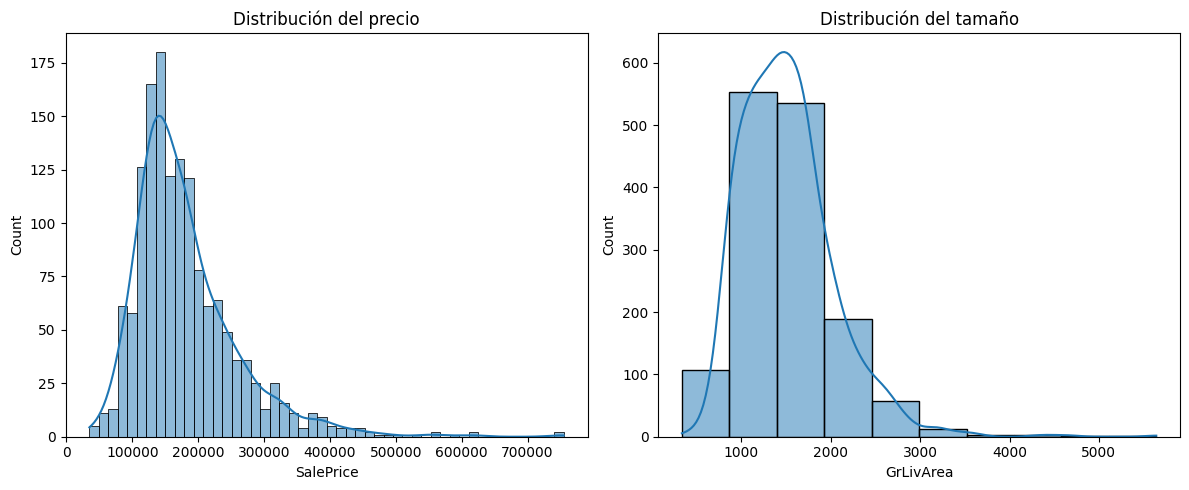

In [9]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
sns.histplot(df['SalePrice'], bins=50, kde=True)
plt.title('Distribución del precio')

plt.subplot(1,2,2)
sns.histplot(df['GrLivArea'], bins = 10, kde=True)
plt.title('Distribución del tamaño')

plt.tight_layout()
plt.show()

Para el tamaño tome la variable que hace refencia a la superficie habitable

## Distribución urbanística de la venta

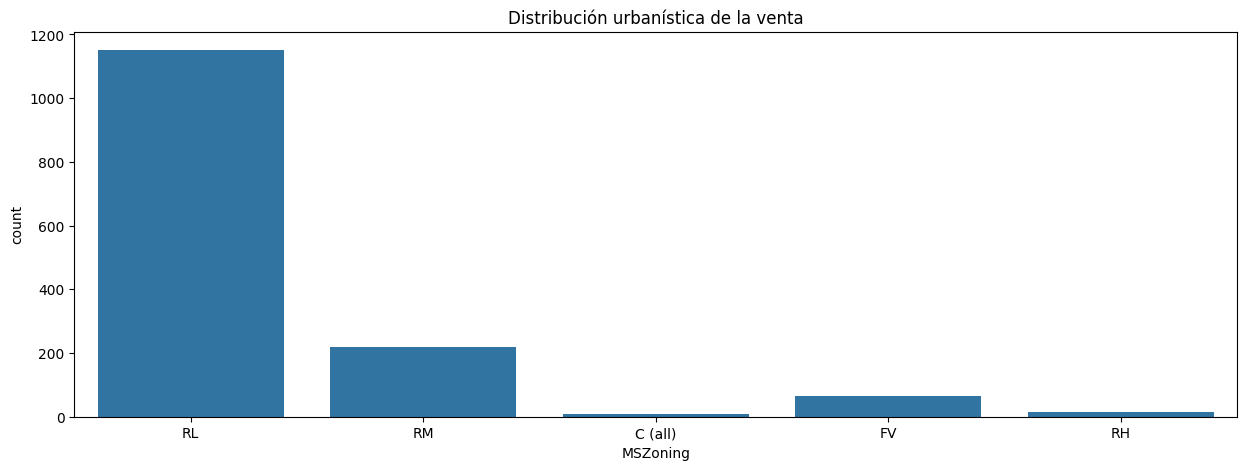

In [10]:
plt.figure(figsize=(15, 5))
sns.countplot(data=df, x='MSZoning')
plt.title('Distribución urbanística de la venta')
plt.show()

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

## Valores nulos

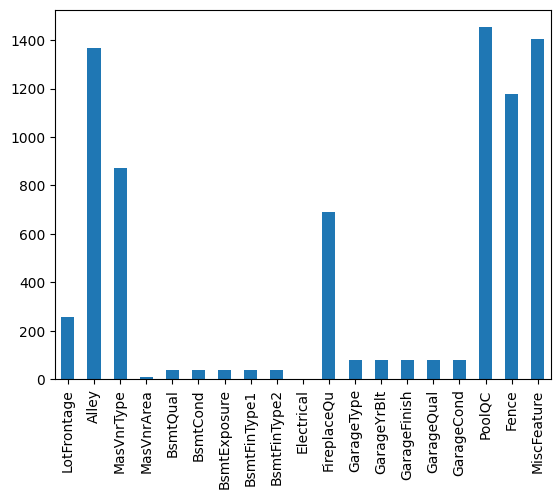

In [11]:
nulls = df.isnull().sum()
nulls = nulls[nulls > 0]
nulls.plot(kind='bar')
plt.show()

Se tienen múltiples características, por lo que solo visualizo las que tienen datos faltantes en general son detalles muy específicos como el tipo de chimenea o otras que pueden estar relacionadas, por ejemplo los metros cuadrados del garage y su capacidad en automóviles.

Por el momento no haré ningún tratamiendo a los datos faltantes, primero veré si son relevantes para algún modelo ya que como lo mencioné arriba, son detalles muy especifícos.

# Eliminación de variables y manejo de variables categóricas

Eliminaré las variables que tienen más de 200 de registros faltantes.

In [12]:
nulls_to_drop = nulls[nulls > 200] #contiene los nombres de las columnas con más de 200 datos nulos
df = df.drop(columns=nulls_to_drop.index)
df.shape

(1460, 74)

Para las variables categóricas, usaré un one-hot encoding, aunque esto aumentará el tamaño de mi data frame, es algo que resolveré más adelante buscando las variables relevantes.

In [13]:
object_columns = df.select_dtypes(include=['object']).columns
df_enc = pd.get_dummies(df, columns=object_columns, dummy_na=True)
df_enc.shape

(1460, 304)

# Selección de variables

Para seleccionar las variables relevantes, usaré la correlación de Pearson y Spearman.

## Correlación Pearson

In [14]:
#Matriz de correlación
p_corr = df_enc.corr() 
#Seleccionamos la variable dependiente
p_sale = p_corr['SalePrice']

#Correlaciones medianas a fuertes
p_high = p_sale[(p_sale > 0.7) | (p_sale < -0.7)]
p_high

OverallQual    0.790982
GrLivArea      0.708624
SalePrice      1.000000
Name: SalePrice, dtype: float64

### Correlación entre variables explicativas

In [15]:
df_enc[['OverallQual', 'GrLivArea']].corr()

,OverallQual,GrLivArea
OverallQual,1.000000,0.593007
GrLivArea,0.593007,1.000000


### Elección variables con coeficiente de Pearson

Al transformar las variables creció mucho el tamaño del data frame, pero mencioné que lo resolvería más adelante, esto porque sospechaba que no todas las variables serían relevantes y descartaría varias con el coeficiente de correlación. Solo dos variables tienen una relación media con el precio de venta y ambas son positivas, las variables son:

    * OverllQual: valora los materiales y acabado de la casa, tiene una correlación cercana al 80% con el precio.
    
    * GriLivArea: mide  los pies cuadrados habitables, tiene una correlación del 70% con el precio.

Además para evitar temas de multicolinealidad, medí la correlación entre estás variables, lo cual arrojo que tiene una débil correlación, por lo que consideraré solo tomar la más alta de ellas (OverallQual) para realizar la regresión.

## Correlación Spearman

In [16]:
#Correlación de Spearman
s_corr = df_enc.corr(method='spearman')
#Seleccionamos la variable dependiente
s_sale = s_corr['SalePrice']
#Correlaciones medianas a fuertes
s_high = s_sale[(s_sale > 0.50) | (s_sale < -0.50)]
s_high

OverallQual         0.809829
YearBuilt           0.652682
YearRemodAdd        0.571159
TotalBsmtSF         0.602725
1stFlrSF            0.575408
GrLivArea           0.731310
FullBath            0.635957
TotRmsAbvGrd        0.532586
Fireplaces          0.519247
GarageYrBlt         0.593788
GarageCars          0.690711
GarageArea          0.649379
SalePrice           1.000000
ExterQual_Gd        0.574642
ExterQual_TA       -0.637785
Foundation_PConc    0.562287
BsmtQual_TA        -0.522456
KitchenQual_TA     -0.581803
Name: SalePrice, dtype: float64

En este caso baje la condicón del coeficiente de correlación, porque pienso usar estás variables en un árbol y solo busco seleccionar algunas variables. Se pueden utilizar otras ténicas para reducir la dimensionalidad como es el análisis de componentes principales, pero por el momento no lo use para hacer usos de técnicas menos complejas.

### Correlación entre variables explicativas.

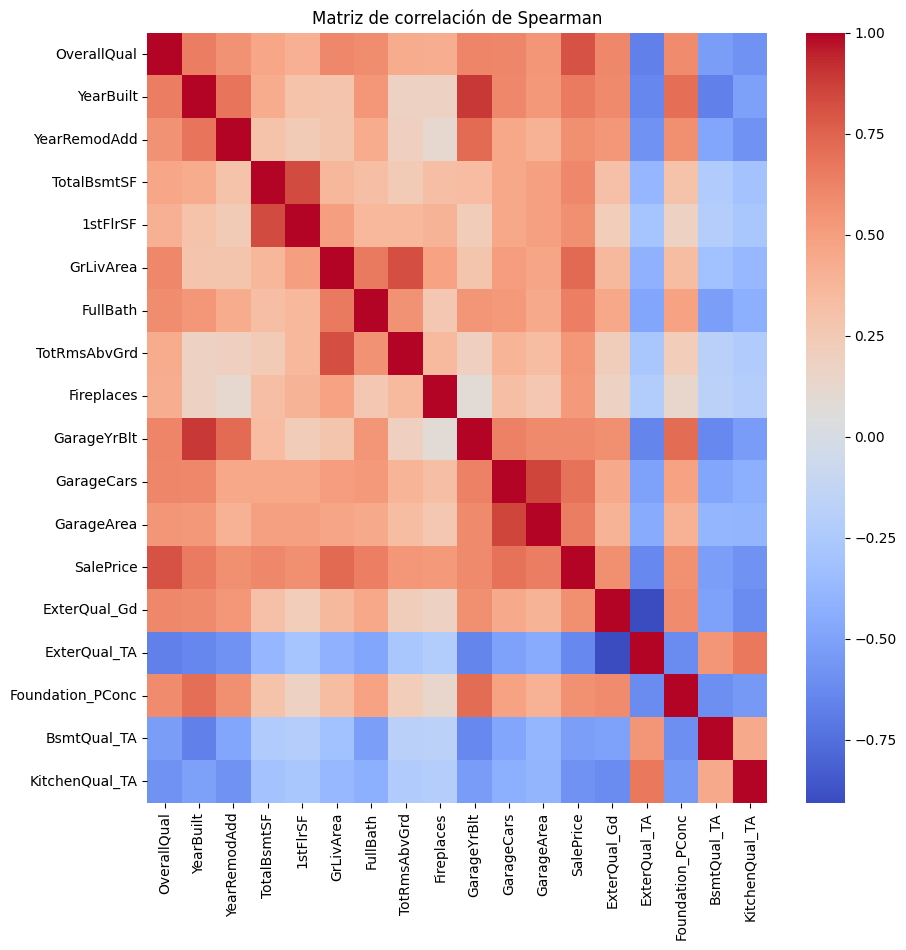

In [17]:
df_enc[['OverallQual', 'GrLivArea']].corr(method='spearman')
plt.figure(figsize=(10,10))
sns.heatmap(s_corr.loc[s_high.index, s_high.index], annot = False, cmap='coolwarm')
plt.title('Matriz de correlación de Spearman')
plt.show()

### Eleccción de variables con coeficiente de Spearman

Existe correlación entre las variables, pero ya mencioné estás variables las pienso utilizar en un árbol por lo que no existe un problema con eso. Por otro lado la mayoría de las correlaciones son positivas.

# Regresión lineal

In [18]:
df_reg = df_enc[['OverallQual', 'SalePrice']]
df_reg.sample(5)

,OverallQual,SalePrice
1435,6,174000
1355,7,170000
1379,5,167500
497,7,184000
1139,5,144000


In [19]:
# Min Max scaler
#Uso este porque zcore es sensiible a valores atípicos ya aquí tenemos varios.
# scaler = MinMaxScaler() 
# columns = df_reg.columns
# df_reg = scaler.fit_transform(df_reg)
# df_reg = pd.DataFrame(df_reg, columns=columns)

# Splitting the dataset into features (X) and target(y)
X = df_reg['OverallQual'] # X = df_reg.drop(columns='SalePrice')
y = df_reg['SalePrice']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=31, shuffle = True)

# Convert series to df
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)


#Display the shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1022, 1), (438, 1), (1022,), (438,))

In [20]:
# Training the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predicting on the testing set
y_pred_train_linear = linear_model.predict(X_train)
y_pred_test_linear = linear_model.predict(X_test)

# Evaluating the Linear Regression model
mse_linear_train = mean_squared_error(y_train, y_pred_train_linear)
rmse_linear_train = root_mean_squared_error(y_train, y_pred_train_linear)
r2_linear_train = r2_score(y_train, y_pred_train_linear)
mse_linear_test = mean_squared_error(y_test, y_pred_test_linear)
rmse_linear_test = root_mean_squared_error(y_test, y_pred_test_linear)
r2_linear_test= r2_score(y_test, y_pred_test_linear)

In [21]:
print(f'MSE Train LR: {mse_linear_train}, RMSE Train LR: {rmse_linear_train}, R2 Train LR: {r2_linear_train}')

MSE Train LR: 2304396748.8440886, RMSE Train LR: 48004.132622557496, R2 Train LR: 0.6243449456514539


In [22]:
print(f'MSE Test LR: {mse_linear_test}, RMSE Test LR: {rmse_linear_test}, R2 Test LR: {r2_linear_test}')

MSE Test LR: 2497408485.7673626, RMSE Test LR: 49974.078138244455, R2 Test LR: 0.62759239319228


In [23]:
cross_val_score(linear_model, X, y, cv=10, verbose=1, scoring='neg_root_mean_squared_error')

array([-40722.27723135, -45909.84079727, -45027.0979542 , -51747.15783271,
       -59593.69061128, -50090.37157212, -43015.46757298, -45365.57097083,
       -58912.31206005, -42448.84950871])

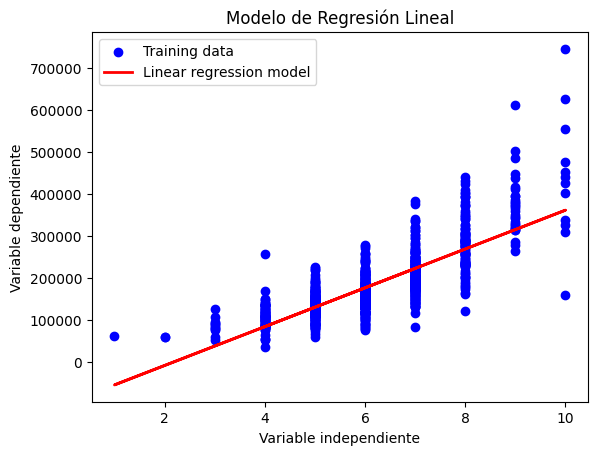

In [24]:
# Graficar los datos de entrenamiento
plt.scatter(X_train, y_train, color='blue', label='Training data')

# Graficar la línea de regresión
plt.plot(X_train, y_pred_train_linear, color='red', linewidth=2, label='Linear regression model')

# Etiquetas y leyenda
plt.xlabel('Variable independiente')
plt.ylabel('Variable dependiente')
plt.title('Modelo de Regresión Lineal')
plt.legend()

# Mostrar la gráfica
plt.show()

## Conclusión regresión lineal

La regresión es medianamente buena, estamos usando una variable explicativa y con ella explico más del 60% de la variabilidad, los errores son consistentes en el conjunto de entrenamiento y el conjunto de validación.

Una venteja que tiene este modelo es la interpretación, ya que es fácil explicar que mientras mejor sea la valoración aumenta el precio. Además es fácil apreciar el error ya que también se mantuvo la escala original, se intento realizar un cambio de escala pero no mejoraba el modelo por lo que opté mantenerla.

# Árbol de decisión regresivo

In [25]:
#Creo el dataset para el árbol.
df_tree = df_enc[list(s_high.index)]
df_tree

#Dividir el dataset en features y target
X_tree = df_tree.drop(['SalePrice'], axis=1) #features
y_tree = df_tree['SalePrice'] #price

#Dividir el conjunto de entrenamiento (train) y de pruebas (test)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, y_tree, test_size=0.2, random_state=42, shuffle=True)

#Muestra el tamañob
X_train_tree.shape, X_test_tree.shape, y_train_tree.shape, y_test_tree.shape 

((1168, 17), (292, 17), (1168,), (292,))

In [26]:
# Training the decision tree model
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train_tree, y_train_tree)

# Predicting on the testing set
y_pred_train_tree = tree_model.predict(X_train_tree)
y_pred_test_tree = tree_model.predict(X_test_tree)

# Evaluating the Decision Tree model
mse_tree_train = mean_squared_error(y_train_tree, y_pred_train_tree)
rmse_tree_train = root_mean_squared_error(y_train_tree, y_pred_train_tree)
mse_tree_test = mean_squared_error(y_test_tree, y_pred_test_tree)
rmse_tree_test = root_mean_squared_error(y_test_tree, y_pred_test_tree)

In [27]:
print(f'MSE Train DT: {mse_tree_train}, RMSE Train DT: {rmse_tree_train}')

MSE Train DT: 1189806.6305650685, RMSE Train DT: 1090.7825771275725


In [28]:
print(f'MSE Test DT: {mse_tree_test}, RMSE Test DT: {rmse_tree_test}')

MSE Test DT: 1327284723.119863, RMSE Test DT: 36431.919015059626


In [29]:
cross_val_score(tree_model, X_tree, y_tree, cv=10, verbose=1, scoring='neg_root_mean_squared_error')

array([-43441.53015789, -46067.60526024, -34651.8481102 , -55208.16635834,
       -47182.96537939, -37281.59453835, -33095.58459407, -35925.24456624,
       -44451.94613257, -37522.61056126])

## Conclusión árbol de decisión.

Es evidente que el árbol tiene un sobre ajuste, aunque la dimensión del árbol se redujo para evitar mucha profundidad. Revisaré con niveles de profundiddad menores para solucionar esto.

## Nivel máximo de profundidad

### Nivel 5

In [30]:
#Nivel 5
tree_model = DecisionTreeRegressor(max_depth=5)
tree_model.fit(X_train_tree, y_train_tree)

# Predicting on the testing set
y_pred_train_tree = tree_model.predict(X_train_tree)
y_pred_test_tree = tree_model.predict(X_test_tree)

# Evaluating the Decision Tree model
mse_tree_train = mean_squared_error(y_train_tree, y_pred_train_tree)
rmse_tree_train = root_mean_squared_error(y_train_tree, y_pred_train_tree)
mse_tree_test = mean_squared_error(y_test_tree, y_pred_test_tree)
rmse_tree_test = root_mean_squared_error(y_test_tree, y_pred_test_tree) 

In [31]:
print(f'MSE Train DT: {mse_tree_train}, RMSE Train DT: {rmse_tree_train}')

MSE Train DT: 872002560.6170244, RMSE Train DT: 29529.68947715205


In [32]:
print(f'MSE Test DT: {mse_tree_test}, RMSE Test DT: {rmse_tree_test}')

MSE Test DT: 1337226560.4189265, RMSE Test DT: 36568.10851573986


### Nivel 3

In [33]:
# #Nivel 3
# tree_model = DecisionTreeRegressor(max_depth=3)
# tree_model.fit(X_train_tree, y_train_tree)

# # Predicting on the testing set
# y_pred_train_tree = tree_model.predict(X_train_tree)
# y_pred_test_tree = tree_model.predict(X_test_tree)

# # Evaluating the Decision Tree model
# mse_tree_train = mean_squared_error(y_train_tree, y_pred_train_tree)
# rmse_tree_train = root_mean_squared_error(y_train_tree, y_pred_train_tree)
# mse_tree_test = mean_squared_error(y_test_tree, y_pred_test_tree)
# rmse_tree_test = root_mean_squared_error(y_test_tree, y_pred_test_tree) 

In [34]:
# print(f'MSE Train DT: {mse_tree_train}, RMSE Train DT: {rmse_tree_train}')

In [35]:
# print(f'MSE Test DT: {mse_tree_test}, RMSE Test DT: {rmse_tree_test}')

## Conclusión niveles de profundidad

Probé con un nivel de profundidad 5 y 3, decidí quedarme con el nivel 5 porque los errores ya no muestran un sobre ajuste e incluso son menores que cuando se baja al nivel 3.

## Árbol

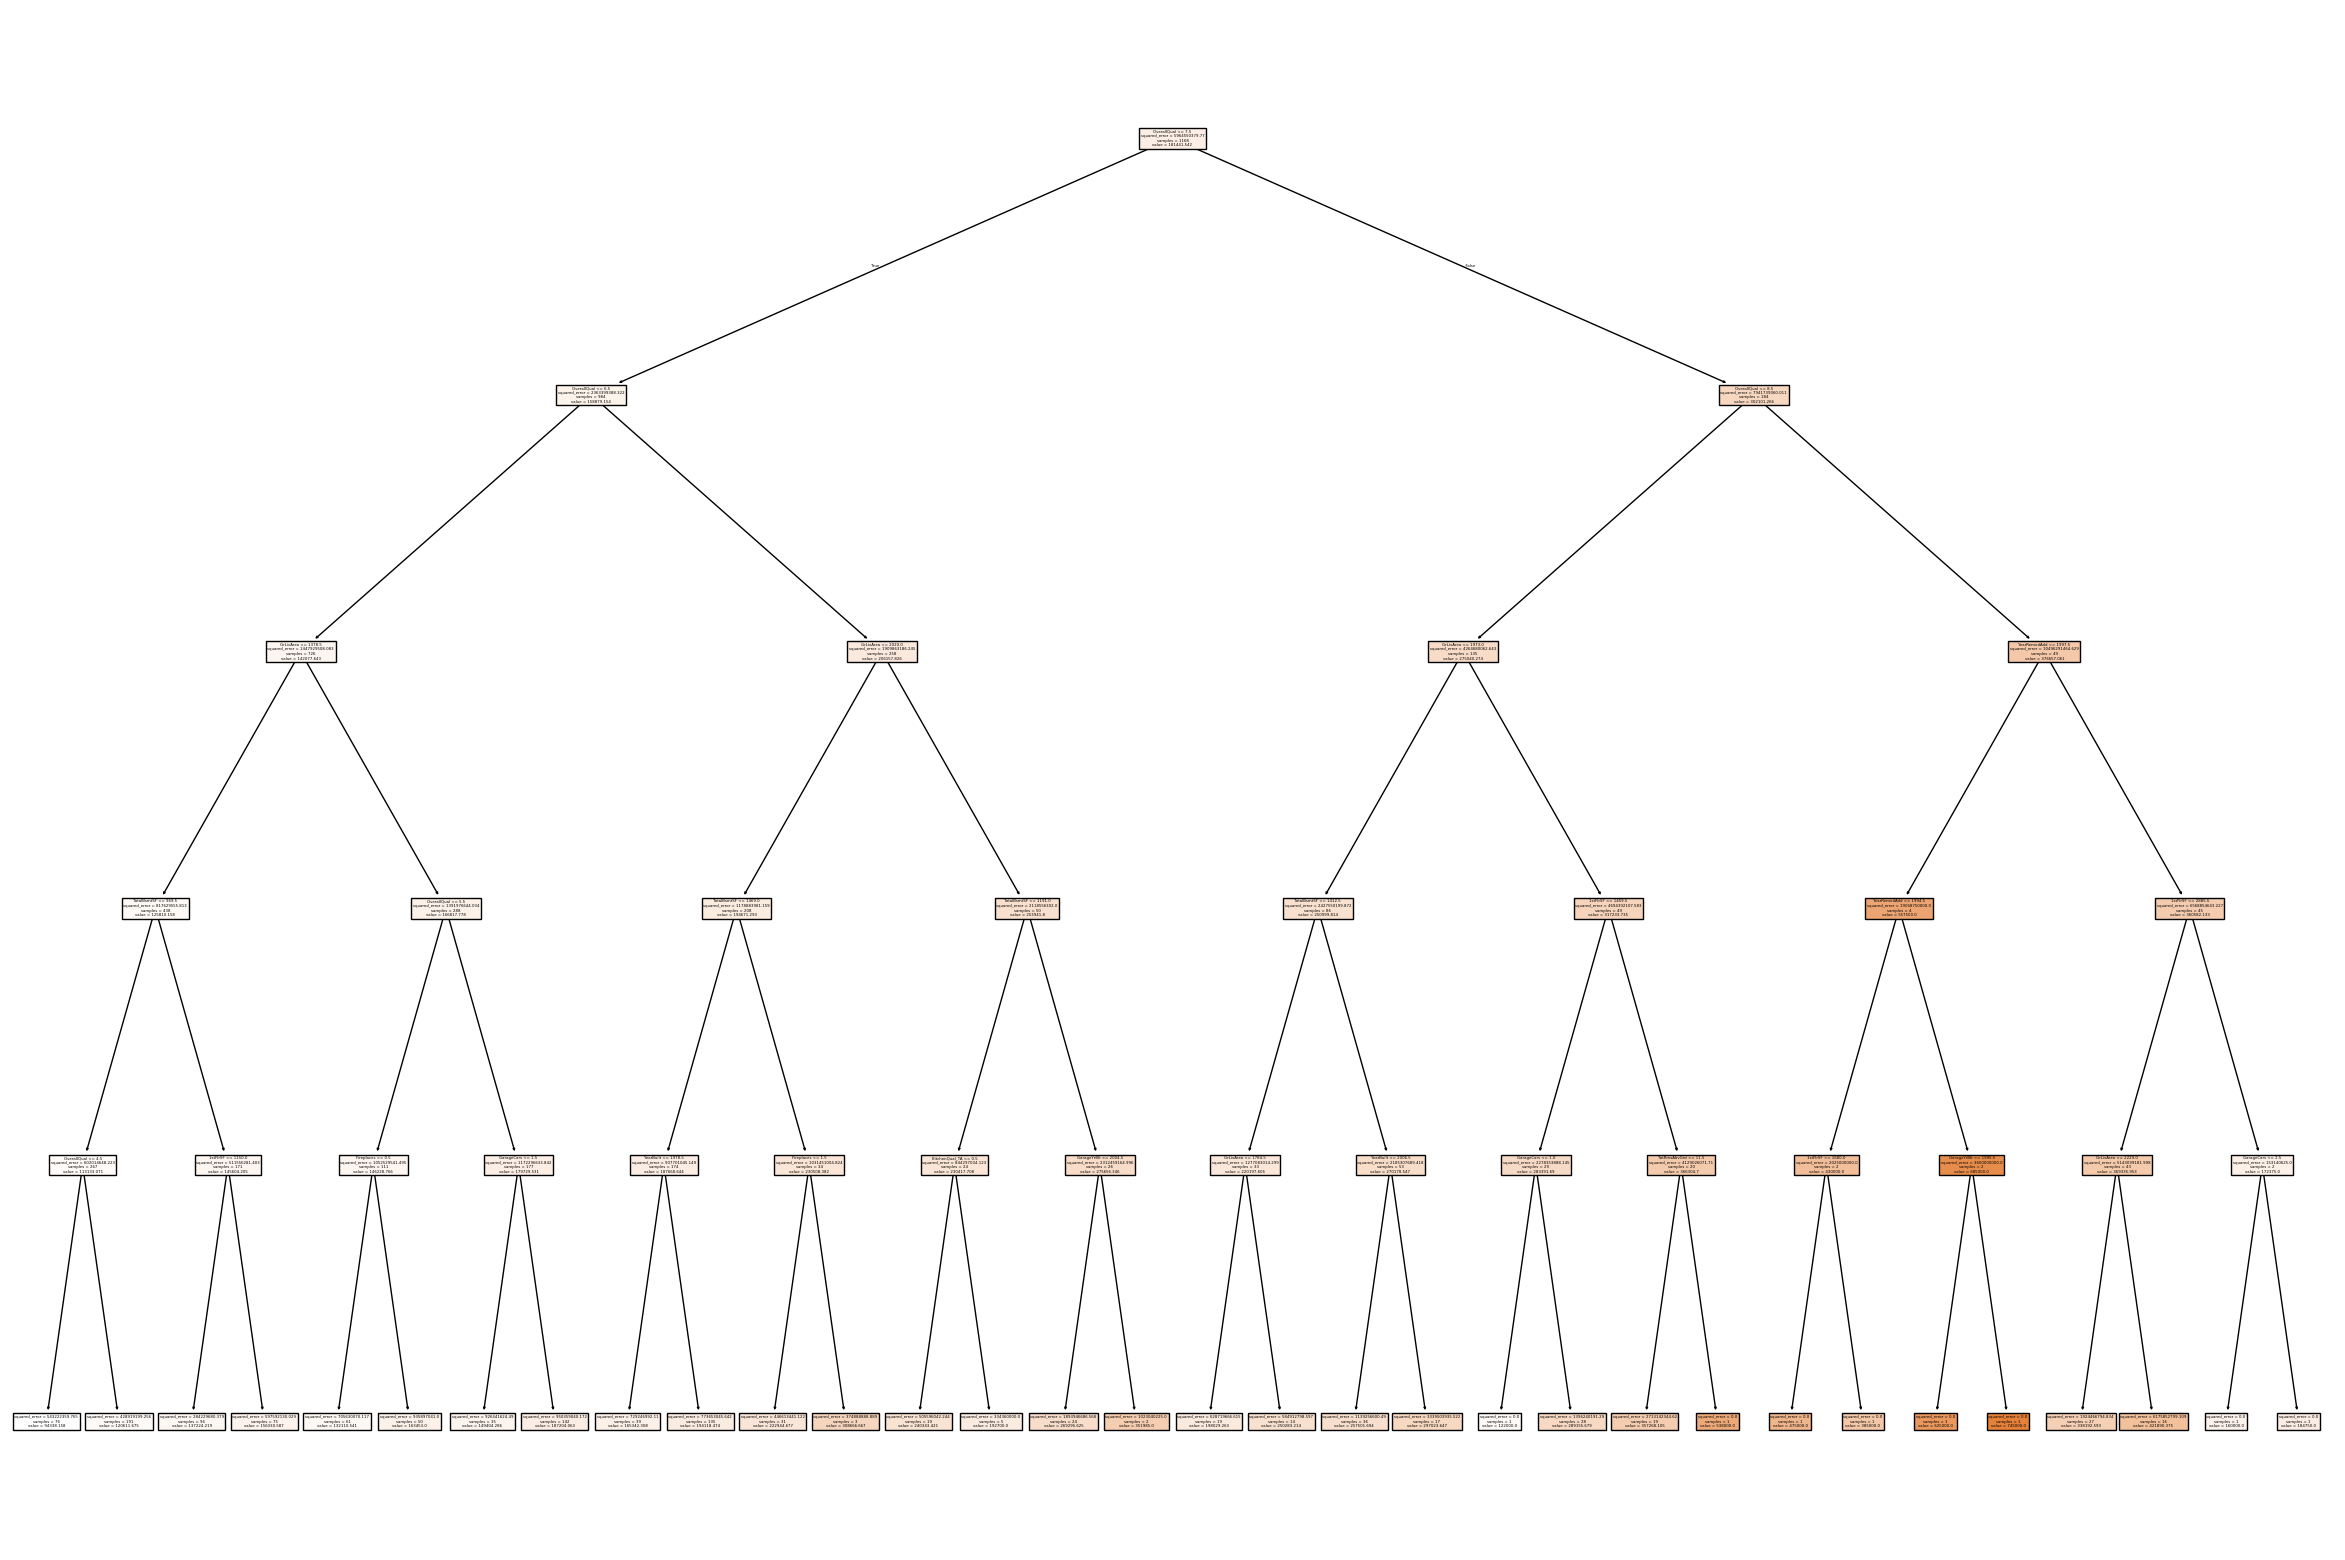

In [36]:
from sklearn.tree import plot_tree

plt.figure(figsize=(30,20))
plot_tree(tree_model, filled=True, feature_names=X_tree.columns)
plt.show()

# Comparación de modelos

## Entrenamiento

In [37]:
pd.DataFrame({'Train': ['Linear Regression', 'Decision Tree'], 'MSE': [mse_linear_train, mse_tree_train], 'RMSE': [rmse_linear_train, rmse_tree_train], 'R2': [r2_linear_train, '-']})

,Train,MSE,RMSE,R2
0,Linear Regression,2.304397e+09,48004.132623,0.624345
1,Decision Tree,8.720026e+08,29529.689477,-


## Prueba

In [38]:
pd.DataFrame({'Test': ['Linear Regression', 'Decision Tree'], 'MSE': [mse_linear_test, mse_tree_test], 'RMSE': [rmse_linear_test, rmse_tree_test], 'R2': [r2_linear_test, '-']})

,Test,MSE,RMSE,R2
0,Linear Regression,2.497408e+09,49974.078138,0.627592
1,Decision Tree,1.337227e+09,36568.108516,-


## Conclusión comparación de modelos

En esta ocasión el árbol es mejor opción porque es más preciso, esto se debe a que podemos agregar más información sin preocuparnos por las asociaciones entre las variables explicativas y con la variable dependiente.

# Normalidad de los residuos

In [39]:
# Calculating errorsprint(f'MSE Test DT: {mse_tree_test}, RMSE Test DT: {rmse_tree_test}')
errors_linear_train = y_train - y_pred_train_linear
errors_tree_train = y_train_tree - y_pred_train_tree
errors_linear_test = y_test - y_pred_test_linear
errors_tree_test = y_test_tree - y_pred_test_tree

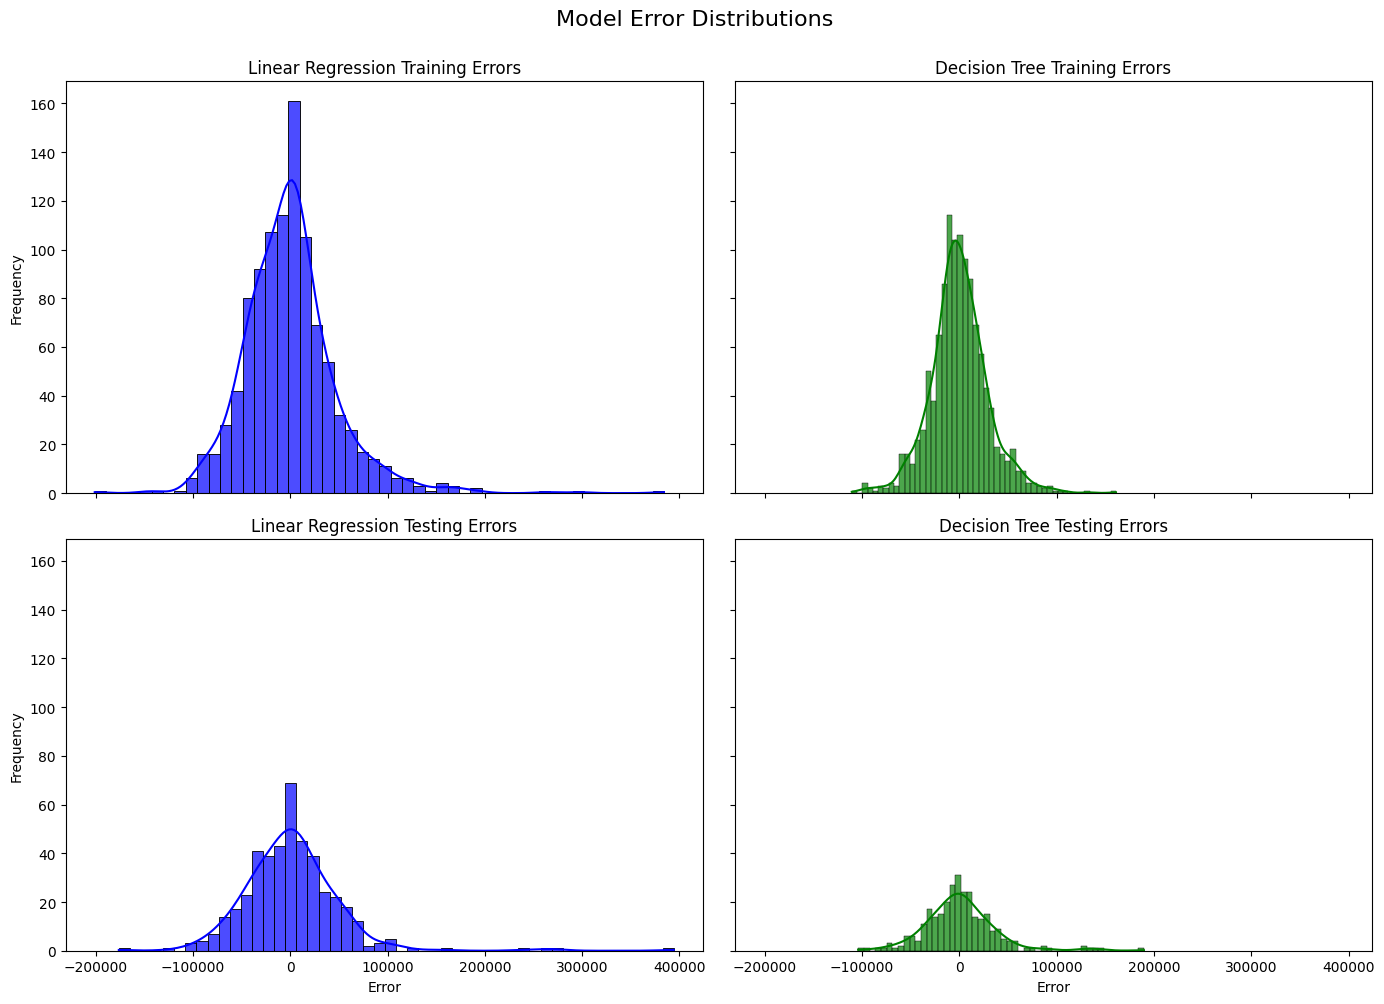

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

sns.histplot(errors_linear_train, bins=50, color='blue', edgecolor='black', alpha=0.7, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Linear Regression Training Errors')
axs[0, 0].set_xlabel('Error')
axs[0, 0].set_ylabel('Frequency')

sns.histplot(errors_tree_train, bins=50, color='green', edgecolor='black', alpha=0.7, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Decision Tree Training Errors')
axs[0, 1].set_xlabel('Error')
axs[0, 1].set_ylabel('Frequency')

sns.histplot(errors_linear_test, bins=50, color='blue', edgecolor='black', alpha=0.7, kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Linear Regression Testing Errors')
axs[1, 0].set_xlabel('Error')
axs[1, 0].set_ylabel('Frequency')

sns.histplot(errors_tree_test, bins=50, color='green', edgecolor='black', alpha=0.7, kde=True, ax=axs[1, 1])
axs[1, 1].set_title('Decision Tree Testing Errors')
axs[1, 1].set_xlabel('Error')
axs[1, 1].set_ylabel('Frequency')

plt.suptitle('Model Error Distributions', fontsize=16, y=1)
plt.tight_layout()
plt.show()

In [41]:
normality_test(errors_linear_train)

D'Agostino-Pearson Test
Test Statistic: 340.4114716451503
p-value: 1.2038937060578313e-74
Conclusion: According to the D'Agostino-Pearson Test, the data is not normally distributed.

Shapiro-Wilk Test
Test Statistic: 0.9246555287275368
p-value: 3.311337678637252e-22
Conclusion: According to the Shapiro-Wilk Test, the data is not normally distributed.

Kolmogorov-Smirnov Test
Test Statistic: 0.5205479452054794
p-value: 3.7226381930427274e-258
Conclusion: According to the Kolmogorov-Smirnov Test, the data is not normally distributed.

Anderson-Darling Test
Test Statistic: 11.807804763353033
At 15.0% significance level, critical value is 0.574
Conclusion at 15.0% significance level: According to the Anderson-Darling Test, the data is not normally distributed.

At 10.0% significance level, critical value is 0.653
Conclusion at 10.0% significance level: According to the Anderson-Darling Test, the data is not normally distributed.

At 5.0% significance level, critical value is 0.784
Conclusi

In [42]:
normality_test(errors_linear_test)

D'Agostino-Pearson Test
Test Statistic: 234.88331987083745
p-value: 9.902278679199006e-52
Conclusion: According to the D'Agostino-Pearson Test, the data is not normally distributed.

Shapiro-Wilk Test
Test Statistic: 0.8733998561252211
p-value: 1.9858708611827747e-18
Conclusion: According to the Shapiro-Wilk Test, the data is not normally distributed.

Kolmogorov-Smirnov Test
Test Statistic: 0.5068493150684932
p-value: 8.874655601120565e-105
Conclusion: According to the Kolmogorov-Smirnov Test, the data is not normally distributed.

Anderson-Darling Test
Test Statistic: 5.91828262714165
At 15.0% significance level, critical value is 0.571
Conclusion at 15.0% significance level: According to the Anderson-Darling Test, the data is not normally distributed.

At 10.0% significance level, critical value is 0.65
Conclusion at 10.0% significance level: According to the Anderson-Darling Test, the data is not normally distributed.

At 5.0% significance level, critical value is 0.78
Conclusion a

In [43]:
laplace_test(errors_linear_train)

Kolmogorov-Smirnov Test for Laplace Distribution
Test Statistic: 0.04390011748211098
p-value: 0.03777113696594614
Conclusion: According to the Kolmogorov-Smirnov Test, the data is not distributed like a Laplace distribution.



## Conclusión normalidad de los residuos.
En todas las pruebas el resultado es no normalidad, esto en parte se puede deber a las largas colas de los errores y su curtosis,

# Descargar imagén del árbol

In [44]:
from sklearn.tree import export_graphviz
import graphviz

# Export the decision tree to a DOT format string
dot_data = export_graphviz(tree_model, out_file=None, 
                           feature_names=X_tree.columns,
                           filled=True)

# Use graphviz to render the decision tree
graph = graphviz.Source(dot_data)

In [45]:
graph.save('./decision_tree.dot')

'./decision_tree.dot'

In [46]:
graph.render()

'decision_tree.dot.pdf'